## Demonstrating aoflagger on eMERLIN data

The aoflagger module (shared library) must be in the path.

In [1]:
import aoflagger as aof
import matplotlib.pyplot as plt
import numpy
import sys

import logging
log = logging.getLogger(__name__)

log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))
log.addHandler(logging.StreamHandler(sys.stderr))

from rascil.processing_components import create_blockvisibility_from_ms, list_ms

Read the 3C277.1_avg Measurement Set

In [2]:
print(list_ms('../data/3C277.1_avg.ms'))

(['1302+5748', '0319+415', '1407+284', '1252+5634', '1331+305'], [0, 1, 2, 3])


Just read one source and one spectral window

In [48]:
bvis = create_blockvisibility_from_ms('../data/3C277.1_avg.ms', selected_sources=['1331+305'], 
                                      selected_dds=[0], datacolumn="CORRECTED_DATA")[0]
from rascil.processing_components import qa_visibility
print(qa_visibility(bvis))

Quality assessment:
	Origin: qa_visibility
	Context: None
	Data:
		maxabs: '12.953973899426211'
		minabs: '0.0'
		rms: '2.0932898208898814'
		medianabs: '0.0'



Make an AOFlagger to use, and define the image_set

In [49]:
ntimes, nant, _, nch, npol = bvis.vis.shape

aoflagger = aof.AOFlagger()
# Shape of returned buffer is actually nch, ntimes
data = aoflagger.make_image_set(ntimes, nch, npol*2)

print("Number of times: " + str(data.width()))
print("Number of antennas:" +str(nant))
print("Number of channels: " + str(data.height()))
print("Number of polarisations: " + str(npol))

flagtabledata = numpy.zeros([ntimes, nant, nant, nch])

Number of times: 315
Number of antennas:6
Number of channels: 128
Number of polarisations: 4


### Make a strategy for this telescope

In [50]:
strategyflags = aof.StrategyFlags.LARGE_BANDWIDTH + aof.StrategyFlags.USE_ORIGINAL_FLAGS + \
    aof.StrategyFlags.ROBUST + aof.StrategyFlags.INSENSITIVE

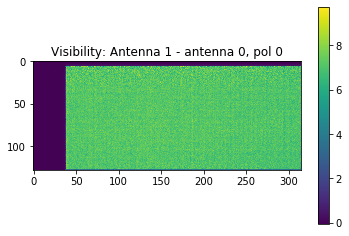

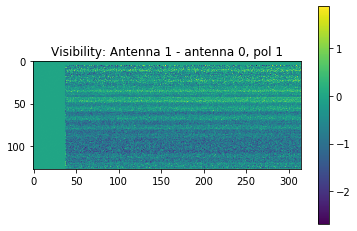

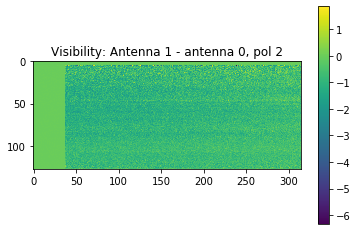

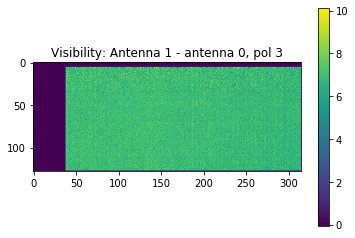

1 0: percentage flags on zero data: 58.86904761904762%


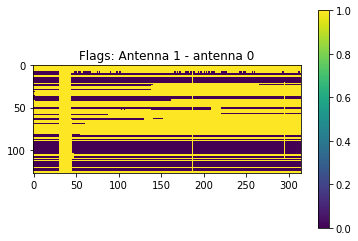

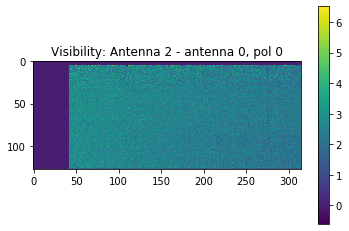

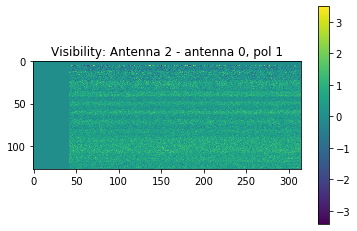

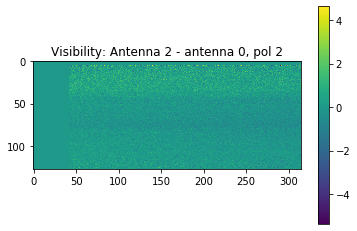

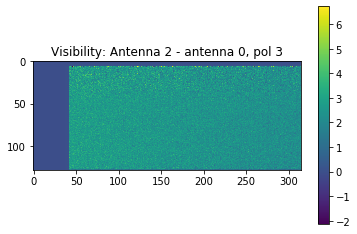

2 0: percentage flags on zero data: 26.378968253968253%


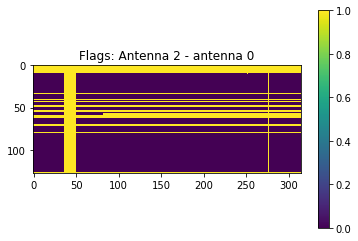

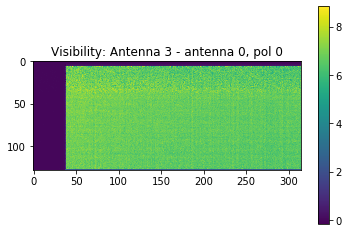

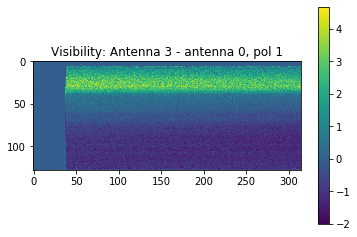

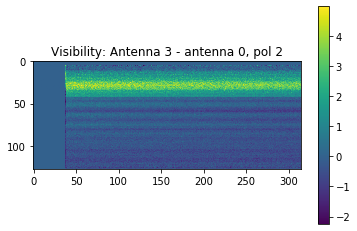

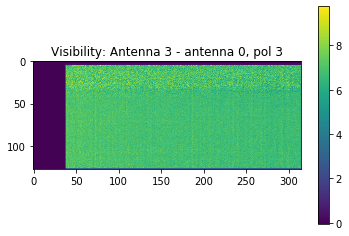

3 0: percentage flags on zero data: 84.79166666666667%


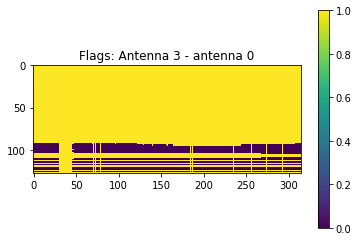

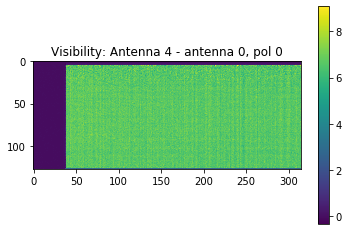

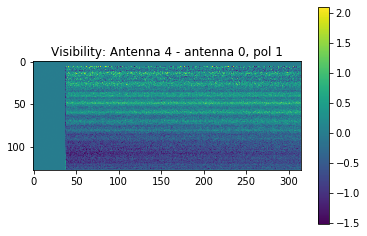

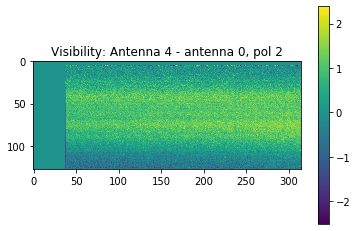

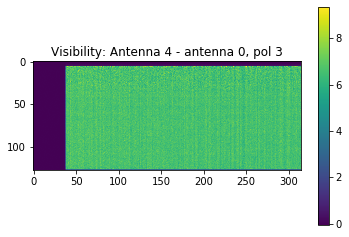

4 0: percentage flags on zero data: 80.83333333333333%


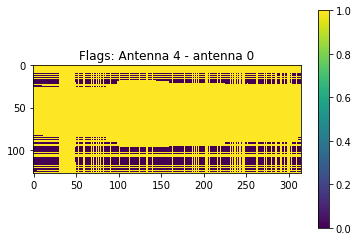

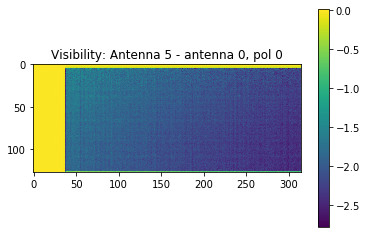

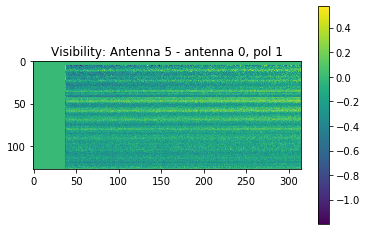

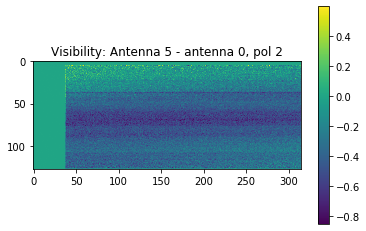

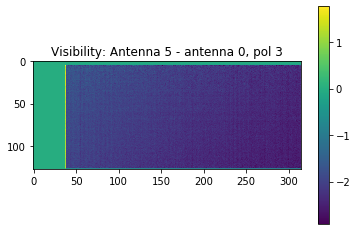

5 0: percentage flags on zero data: 85.37698412698413%


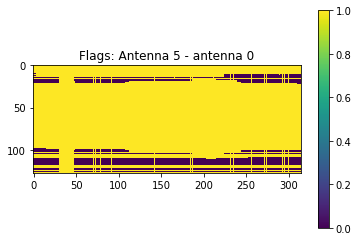

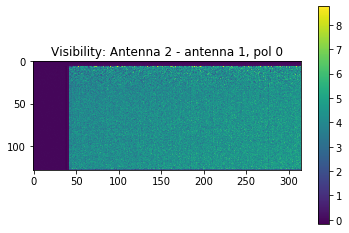

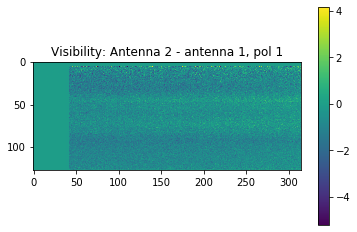

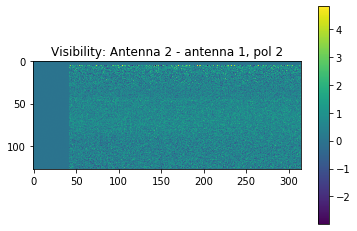

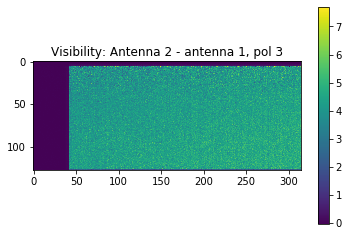

2 1: percentage flags on zero data: 14.556051587301587%


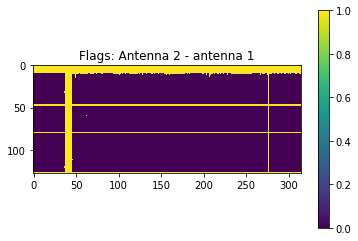

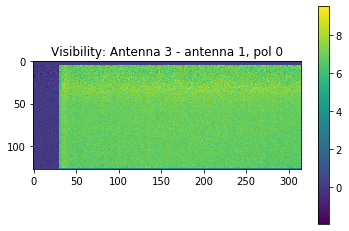

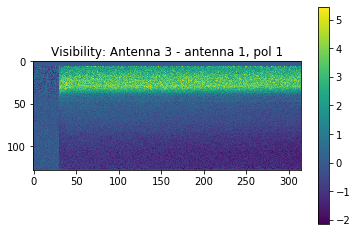

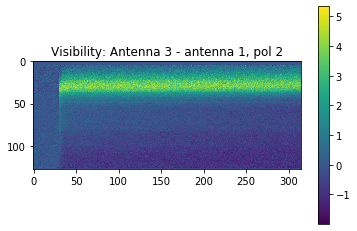

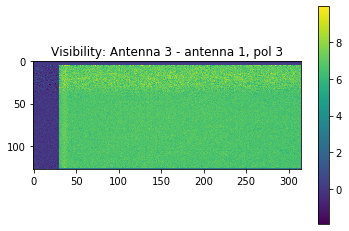

3 1: percentage flags on zero data: 52.89186507936508%


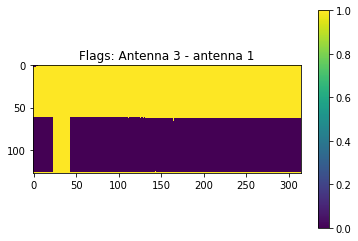

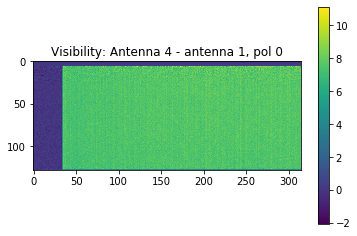

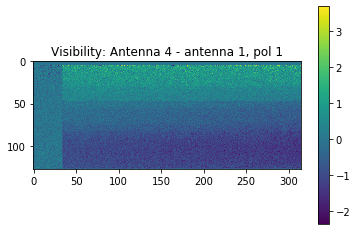

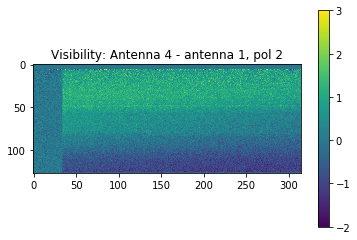

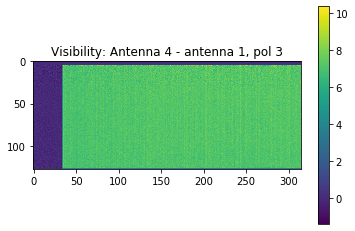

4 1: percentage flags on zero data: 23.45734126984127%


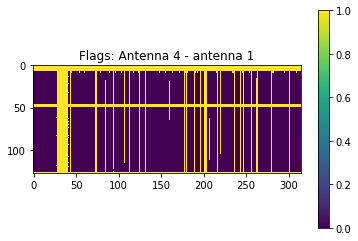

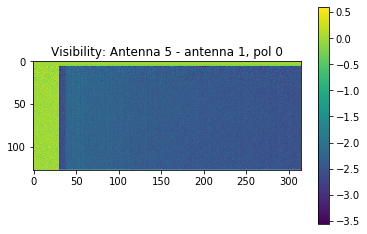

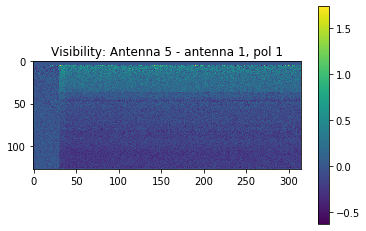

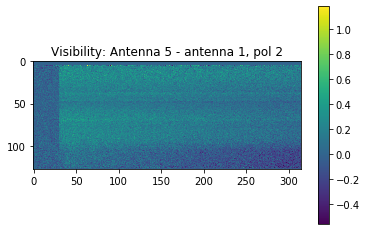

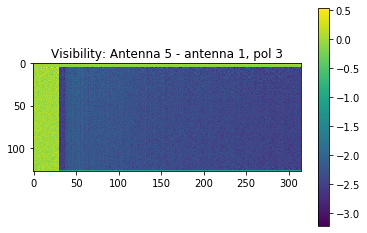

5 1: percentage flags on zero data: 26.607142857142858%


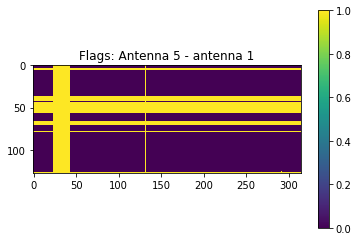

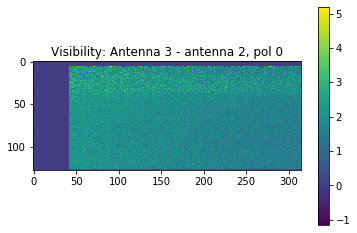

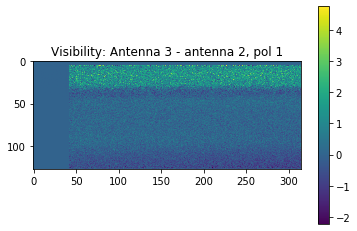

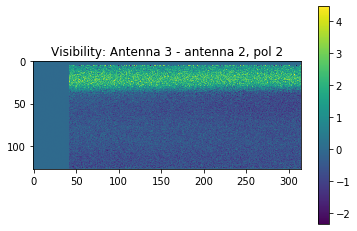

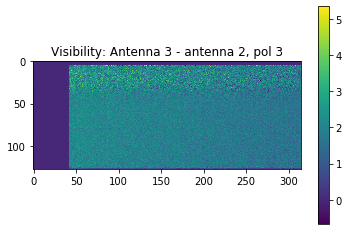

3 2: percentage flags on zero data: 36.688988095238095%


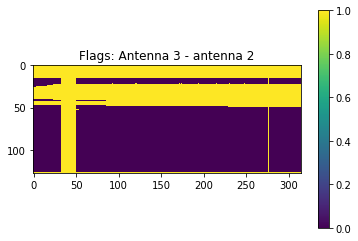

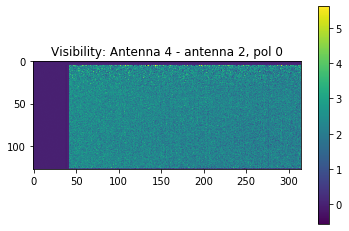

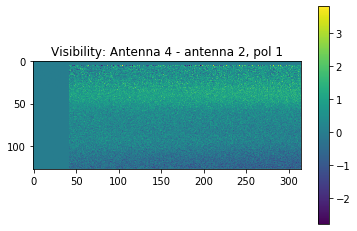

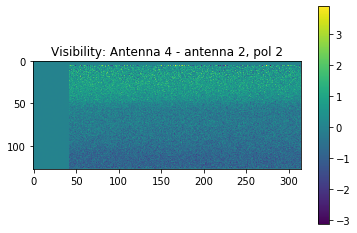

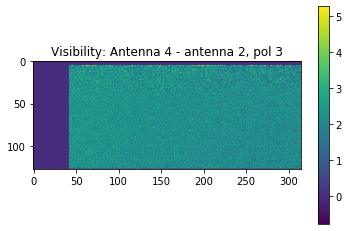

4 2: percentage flags on zero data: 18.266369047619047%


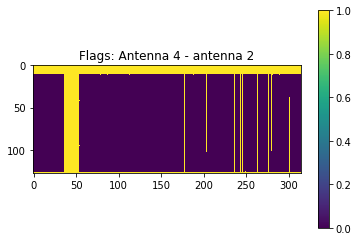

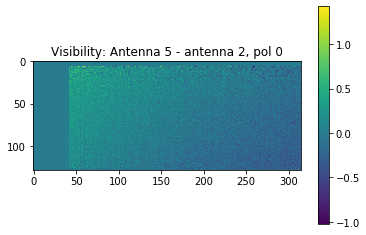

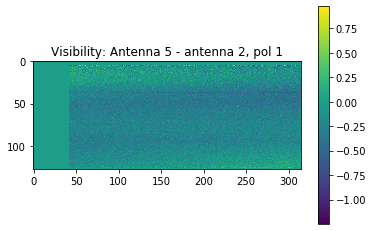

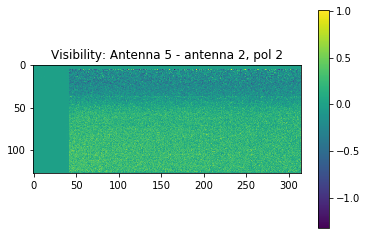

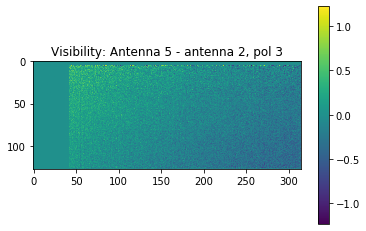

5 2: percentage flags on zero data: 12.135416666666666%


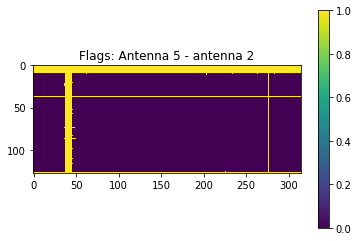

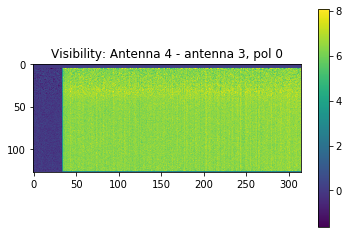

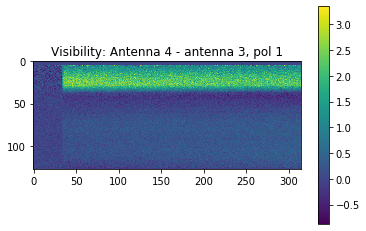

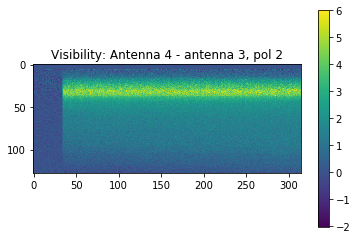

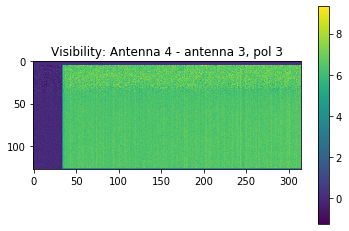

4 3: percentage flags on zero data: 61.52281746031746%


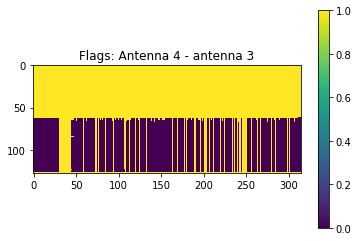

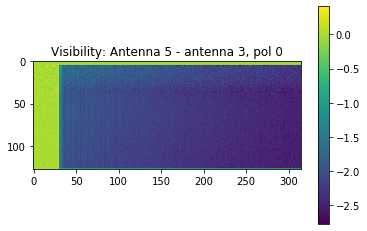

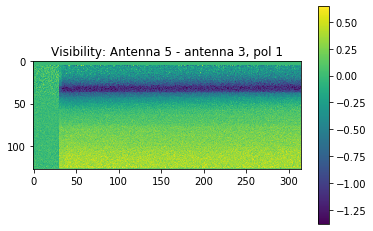

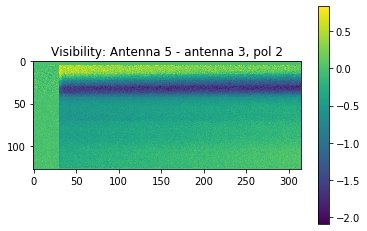

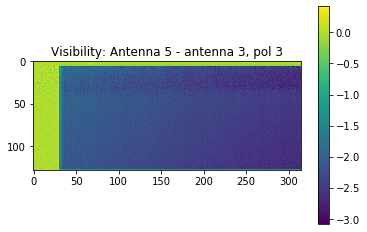

5 3: percentage flags on zero data: 68.07539682539682%


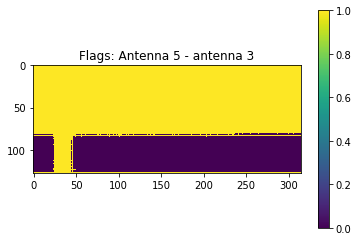

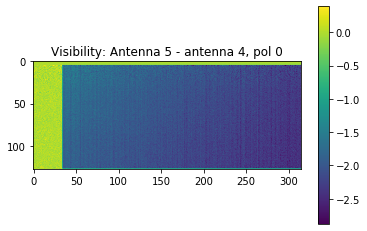

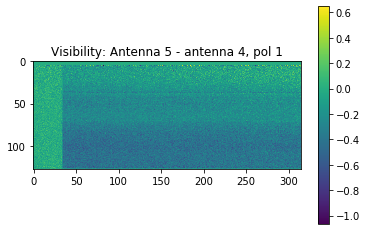

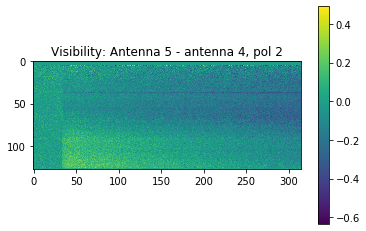

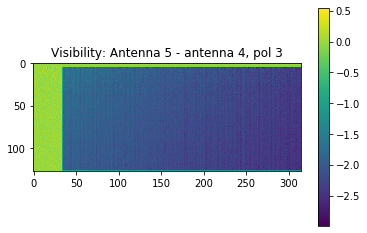

5 4: percentage flags on zero data: 36.70386904761905%


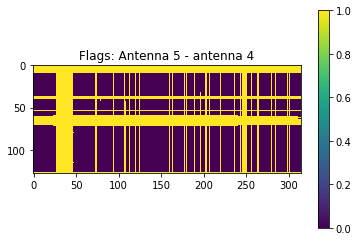

In [52]:
#unsigned strategyFlags, double frequency, double timeRes, double frequencyRes
strategy = aoflagger.make_strategy(aof.TelescopeId.Generic, strategyflags, bvis.frequency[0], 
                                   bvis.integration_time[0], bvis.channel_bandwidth[0])

doplot=True

for a2 in range(0, nant-1):
    for a1 in range(a2+1,nant):
        for pol in range(npol):
            data.set_image_buffer(2*pol,   numpy.real(bvis.vis[:,a1,a2,:,pol]).T)
            data.set_image_buffer(2*pol+1, numpy.imag(bvis.vis[:,a1,a2,:,pol]).T)
            if doplot:
                title = 'Visibility: Antenna %d - antenna %d, pol %d' % (a1, a2, pol)
                plt.imshow(numpy.real(bvis.vis[:,a1,a2,:,pol]).T, cmap='viridis')
                plt.title(title)
                plt.colorbar()
                plt.show()


        flags = aoflagger.run(strategy, data)
        flagvalues = flags.get_buffer() * 1
        flagtabledata[:,a1,a2,:] = flagvalues.T
        flagcount = sum(sum(flagvalues))
        print(str(a1) + " " + str(a2) + ": percentage flags on zero data: " 
              + str(flagcount * 100.0 / (nch*ntimes)) + "%")
        if doplot:
            title = 'Flags: Antenna %d - antenna %d' % (a1, a2)
            plt.imshow(flagvalues, cmap='viridis')
            plt.title(title)
            plt.colorbar()
            plt.show()